In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import bct
import json
from os import makedirs
from matplotlib.colors import LinearSegmentedColormap
from os.path import join, exists
from nilearn.plotting import plot_glass_brain, plot_roi, find_parcellation_cut_coords
#import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
sns.set_context('poster', font_scale=0.85)
import matplotlib.pyplot as plt


In [2]:
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff


In [3]:
sink_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output'
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures/'
data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data'
roi_dir = '/Users/kbottenh/Dropbox/Data/templates/shen2015/'


shen = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'craddock2012']

tasks = {'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0, 1]}],
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                 {'runs': [0, 1, 2]}]}

tasks = ['fci', 'retr']
sessions = [0, 1]
sesh = ['pre', 'post']
conditions = ['high-level', 'lower-level']
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

# Data wrangling
Nodal efficiency data needs to be scaled according to mean efficiency across empirically estimated null models. Imputation should happen, too.

In [4]:

# # Data wrangling
# Nodal efficiency data is currently in an <i>incredbily</i> long, multi-indexed dataframe. 
# Here, we transform it into wide data (dataframe per condition per task per session) for ease of analysis later.
null_df = pd.read_csv(join(sink_dir, 'local_efficiency', 'task_eff_dist.csv'), 
                      index_col=[0,1,2,3], header=0)

big_df = pd.read_csv(join(data_dir, 'rescored', 'physics_learning-local_efficiency-BayesianImpute.csv'), 
                index_col=0, header=0)

In [5]:
session = 1
for mask in masks:
    for task in tasks:
        for condition in conditions:
            if condition == 'high-level':
                cond = 'physics'
            elif condition == 'lower-level':
                cond = 'control'
            conns = big_df.filter(regex='lEff.*, {0},.*{1}.*{2}.*{3}.*'.format(session,
                                                                               task, 
                                                                               condition, 
                                                                               mask)).columns
            print(conns[:2])
            new_conns = []
            for conn in conns:
                new_conn = conn.replace('\', \'', '_')
                new_conn = new_conn.replace('\', ', '_')
                new_conn = new_conn.replace(', \'', '_')
                new_conn = new_conn[2:-2]
                new_conns.append(new_conn)
                big_df.rename({conn: new_conn}, axis=1, inplace=True)
                
            print(new_conns[:2])
            big_df[new_conns] = big_df[new_conns] / null_df.loc[sesh[session],
                                                                task,
                                                                cond,
                                                                mask]['mean']

Index(['('lEff1', 1, 'fci', 'high-level', 'shen2015')', '('lEff2', 1, 'fci', 'high-level', 'shen2015')'], dtype='object')
['lEff1_1_fci_high-level_shen2015', 'lEff2_1_fci_high-level_shen2015']
Index([], dtype='object')
[]
Index(['('lEff1', 1, 'retr', 'high-level', 'shen2015')', '('lEff2', 1, 'retr', 'high-level', 'shen2015')'], dtype='object')
['lEff1_1_retr_high-level_shen2015', 'lEff2_1_retr_high-level_shen2015']
Index([], dtype='object')
[]
Index(['('lEff1', 1, 'fci', 'high-level', 'craddock2012')', '('lEff2', 1, 'fci', 'high-level', 'craddock2012')'], dtype='object')
['lEff1_1_fci_high-level_craddock2012', 'lEff2_1_fci_high-level_craddock2012']
Index([], dtype='object')
[]
Index(['('lEff1', 1, 'retr', 'high-level', 'craddock2012')', '('lEff2', 1, 'retr', 'high-level', 'craddock2012')'], dtype='object')
['lEff1_1_retr_high-level_craddock2012', 'lEff2_1_retr_high-level_craddock2012']
Index([], dtype='object')
[]


In [6]:
conn_list = []
for i in np.arange(0,268):
    conn = big_df.filter(regex='.*_1_fci_high-level_{0}'.format(mask)).columns[i].split('_')[0]
    conn_list.append(conn)

In [7]:
for iq in iqs:
    big_df['delta{0}'.format(iq)] = big_df['{0}2'.format(iq)] - big_df['{0}1'.format(iq)]
    big_df['delta{0}XSex'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['F']
    big_df['{0}2XSex'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['F']
    big_df['delta{0}XClass'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['Mod']
    big_df['{0}2XClass'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['Mod']
    big_df['SexXClass'] = big_df['F'] * big_df['Mod']
    big_df['delta{0}XSexXClass'.format(iq)] = big_df['delta{0}'.format(iq)] * big_df['SexXClass']
    big_df['{0}2XSexXClass'.format(iq)] = big_df['{0}2'.format(iq)] * big_df['SexXClass']

# Regress local efficiency on IQ and all the covariates
- Permuted OLS tests each `target_var` independently, while regressing out `confounding_vars`, so to run a multiple regression, we test each variable of interest, separately, and put all other variables in the regression in with the confounds. This way, we can test interactions <i>with</i> main effects.
- Maximum p-values are saved in `sig` dictionary and for each significant variable, the p- and t-values for each node are saved in `nodaleff_sig`.
- For each regression, maximum <i>p</i>- and <i>t</i>-values are stored in `params`, along with nodes whose local efficiency is significantly related to each parameter, are stored <i> by variable</i>.


In [9]:
sig = pd.DataFrame(index=masks)
nodaleff_sig = pd.DataFrame(index=conn_list)
alpha = 0.05

adj_a = 1 - (1 - alpha)**(1/8)
nloga = -np.log10(adj_a)
print('adjusted alpha across ', nloga)
    
for mask in masks:
    effs = {'post phys fci': {'conns': big_df.filter(regex='.*_1_fci_high-level_{0}'.format(mask)).columns,
                              'iqs': ['deltaPRI', 'deltaFSIQ', 'PRI2', 'FSIQ2']},
            'post phys retr': {'conns': big_df.filter(regex='.*_1_retr_high-level_{0}'.format(mask)).columns,
                               'iqs': ['WMI2', 'VCI2']}}
    iqs = effs['post phys fci']['iqs'] + effs['post phys retr']['iqs']
    variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 'StrtLvl', 'fd']
    index = pd.MultiIndex.from_product([iqs, effs.keys(), variables])
    params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'nodes'])
    for key in effs.keys():
        print(key)
        efficiencies = effs[key]['conns']
        iqs = effs[key]['iqs']
        
        for iq in iqs:
            print(iq)
            variables = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                         '{0}XSexXClass'.format(iq),
                         'F', 'StrtLvl', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(key)]
            for var in variables:
                covariates = list(set(variables) - set([var]))
                p, t, _ = permuted_ols(big_df[var], 
                                       big_df[efficiencies], 
                                       big_df[covariates],
                                       n_perm=10000)
                print(key, var, 'max p-val:',  np.max(p[0]))
                sig.at[mask, '{0}, {1}, {2}'.format(variables[0], key, var)] = np.max(p[0])
                nodaleff_sig['{0} {1} {2} {3} p'.format(mask, iq, var, key)] = p.reshape((268,)).T
                nodaleff_sig['{0} {1} {2} {3} t'.format(mask, iq, var, key)] = t.reshape((268,)).T
                #nodaleff_sig.to_csv(join(sink_dir, '{0}-{1}-{2}-{3}-nodal_efficiency-p+tvals.csv'.format(mask, key, iq, var)))
                sig_nodes = nodaleff_sig[nodaleff_sig['{0} {1} {2} {3} p'.format(mask, iq, var, key)] >= nloga].index
                
                print('# significant nodes:', len(sig_nodes))
                if key in var:
                    params.loc[iq, key, 'fd']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, 'fd']['max t'] = np.max(t[0])
                    params.loc[iq, key, 'fd']['nodes'] = list(sig_nodes)
                elif iq in var:
                    if 'Sex' in var:
                        if 'Class' in var:
                            params.loc[iq, key, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXsexXclass']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXsexXclass']['nodes'] = list(sig_nodes)
                        else:
                            params.loc[iq, key, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXsex']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXsex']['nodes'] = list(sig_nodes)
                    if 'Class' in var:
                        if not 'Sex' in var:
                            params.loc[iq, key, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXclass']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXclass']['nodes'] = list(sig_nodes)
                    else:
                        params.loc[iq, key, 'iq']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, key, 'iq']['max t'] = np.max(t[0])
                        params.loc[iq, key, 'iq']['nodes'] = list(sig_nodes)
                elif var == 'SexXClass':
                    params.loc[iq, key, 'sexXclass']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, 'sexXclass']['max t'] = np.max(t[0])
                    params.loc[iq, key, 'sexXclass']['nodes'] = list(sig_nodes)
                else:
                    params.loc[iq, key, var]['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, var]['max t'] = np.max(t[0])
                    params.loc[iq, key, var]['nodes'] = list(sig_nodes)
    params.to_csv(join(sink_dir, '{0}-params-permutedOLS-efficiency.csv'.format(mask)))
sig.to_csv(join(sink_dir, 'max-nlogp-local_efficiency-permutedOLS.csv'))
nodaleff_sig.to_csv(join(sink_dir, 'nodal_efficiency-nlogp+tvals.csv'.format(mask, key, iq, var)))

adjusted alpha across  2.194420924596385
post phys fci
deltaPRI
post phys fci deltaPRI max p-val: 1.6252950812667588
# significant nodes: 0
post phys fci deltaPRIXSex max p-val: 0.4351407547476579
# significant nodes: 0
post phys fci deltaPRIXClass max p-val: 1.414582697768362
# significant nodes: 0
post phys fci deltaPRIXSexXClass max p-val: 0.2722582530939567
# significant nodes: 0
post phys fci F max p-val: 0.066353718318968
# significant nodes: 0
post phys fci StrtLvl max p-val: 0.33044764625254935
# significant nodes: 0
post phys fci SexXClass max p-val: 0.006960066578800675
# significant nodes: 0
post phys fci Age max p-val: 1.0685855565878577
# significant nodes: 0
post phys fci Mod max p-val: 0.22794185799985078
# significant nodes: 0
post phys fci post phys fci fd max p-val: 3.301073422940844
# significant nodes: 90
deltaFSIQ
post phys fci deltaFSIQ max p-val: 1.127304599804194
# significant nodes: 0
post phys fci deltaFSIQXSex max p-val: 0.07778520384389605
# significant node

post phys retr StrtLvl max p-val: 0.22581852240794367
# significant nodes: 0
post phys retr SexXClass max p-val: 1.6108773429123302
# significant nodes: 0
post phys retr Age max p-val: 0.3082549028741643
# significant nodes: 0
post phys retr Mod max p-val: 0.08580607950912163
# significant nodes: 0
post phys retr post phys retr fd max p-val: 1.6364314473847184
# significant nodes: 0
VCI2
post phys retr VCI2 max p-val: 0.2588918284250776
# significant nodes: 0
post phys retr VCI2XSex max p-val: 0.6676049673612573
# significant nodes: 0
post phys retr VCI2XClass max p-val: 0.5173127271969198
# significant nodes: 0
post phys retr VCI2XSexXClass max p-val: 0.5470310361554075
# significant nodes: 0
post phys retr F max p-val: 0.7066808725654172
# significant nodes: 0
post phys retr StrtLvl max p-val: 0.3627538795986882
# significant nodes: 0
post phys retr SexXClass max p-val: 0.5383948592134077
# significant nodes: 0
post phys retr Age max p-val: 0.40070629428437354
# significant nodes: 0


In [12]:
for col in sig.columns:
    if sig.at['shen2015', col] > nloga:
        if sig.at['craddock2012', col] > nloga:
            print(col)

deltaPRI, post phys fci, post phys fci fd
deltaFSIQ, post phys fci, post phys fci fd
PRI2, post phys fci, post phys fci fd
FSIQ2, post phys fci, post phys fci fd


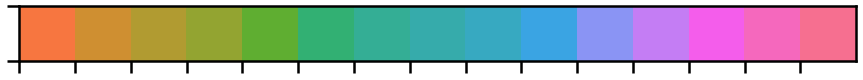

In [13]:
n_map = int(len(params[params['max nlog(p)'] > 1].index)) + 1
interval = 1 / n_map
husl_pal = sns.husl_palette(n_colors=n_map, h=interval)
husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=n_map)
sns.palplot(husl_pal)

crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

In [14]:
params

max nlog(p)     max t nodes
deltaPRI post phys fci  iq              0.372985     1.633    []
                        iqXsex          0.372985     1.633    []
                        iqXclass         2.19386  0.904928    []
                        iqXsexXclass    0.946581   1.12528    []
                        sexXclass       0.221169   2.08904    []
...                                          ...       ...   ...
VCI2     post phys retr F               0.706681  0.967563    []
                        Mod              0.48364     1.007    []
                        Age             0.400706   1.08782    []
                        StrtLvl         0.362754   1.98286    []
                        fd               1.99572   3.62025    []

[120 rows x 3 columns]

('deltaPRI', 'post phys fci', 'iqXclass')
1 ('deltaPRI', 'post phys fci', 'iqXclass')


/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


IndexError: list index out of range

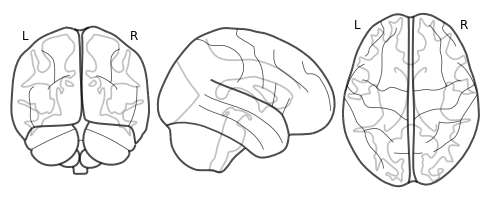

In [15]:
empty_nii = nib.load(join(roi_dir, 'roi101.nii.gz'))
empty_roi = empty_nii.get_fdata() * 0
empty = nib.Nifti1Image(empty_roi, empty_nii.affine)
g = plot_glass_brain(empty, colorbar=False, vmin=0.5, vmax=n_map)
i = 0


for var in params.index:
    if 'fd' not in var:
        if params.loc[var]['max nlog(p)'] > 2:
            print(var)
            i += 1
            husl_pal = sns.husl_palette(h=interval * i, n_colors=n_map)
            rois = None
            print(i, var)
            corr_nodes = []
            #tvals = params.loc[i]['max t']
            nodes = params.loc[var]['nodes']
            print('first nodes raw', nodes[0])
            corr_nodes.append(int(nodes[0]))
            roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(nodes[0]+1))))
            roi = roi_nifti.get_fdata()
            rois = (roi * i)
            print(int(nodes[0])+1, np.max(rois))
            if len(nodes) > 1:
                for node in nodes[1:]:
                    node += 1
                    corr_nodes.append(int(node))
                    roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(node)+1)))
                    roi = roi_nifti.get_fdata()
                    rois += (roi * i)
                    print(int(node), np.max(rois))
            else:
                pass
            np.savetxt(join(fig_dir, '{1}-{0}.txt'.format(i, var)), corr_nodes, delimiter=',')
            rois_nifti = nib.Nifti1Image(rois, roi_nifti.affine)
            rois_nifti.to_filename(join(data_dir, 'output/local_efficiency', '{0}_nodes.nii.gz'.format(var)))
            h = plot_glass_brain(rois_nifti, cmap=LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=3))
            h.savefig(join(fig_dir, '{0}-{1}_ROIs.png'.format(i, var)), dpi=300)

            husl_pal = sns.husl_palette(n_colors=int(n_map), h=interval*i)
            g.add_contours(rois_nifti, colors=husl_pal, filled=True, alpha=0.7)

        else:
            pass

g.savefig(join(fig_dir, 'LEffXIQ_ROIs.png'), dpi=300)

In [ ]:
all_data = big_df
all_data.columns = all_data.columns.str.replace(', ', '_')

all_data.filter(regex='lEff.*').columns

In [ ]:
n_col = int(len(nodaleff_sig.columns)/2) + 1
husl_pal = sns.husl_palette(n_colors=int(n_col))
husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=int(n_col))
i = 0
for var in params.index:
    if 'fd' not in var:
        if params.loc[var]['max nlog(p)'] > 2:
            iq = var[0]
            task = var[1]
            dat = effs[task]['conns']
            husl_pal = sns.husl_palette(h=(interval*i), n_colors=int(n_col))

            print(var, i)
            
            nodes = params.loc[var]['nodes']
            print(nodes)
            for node in nodes:
                node = 'lEff{0}'.format(node+1)
                if var[-1] == 'iqXsex':
                    #print(iq, 'x Sex', node, nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                    h = sns.lmplot(iq, node, data=all_data, hue='F', palette=crayons_d)
                    h.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iqXsexXclass':
                    #print(iq, 'x Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                    h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                    h.savefig(join(fig_dir, '{0}-{1}-scatter-f.png'.format(i, var, node)), dpi=300)
                    h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 0], hue='Mod', palette=m_2)
                    h.savefig(join(fig_dir, '{0}-{1}-scatter-m.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iqXclass':
                    #print(iq, 'x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    h = sns.lmplot(iq, node, data=all_data, hue='Mod', palette=grays)
                    h.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'sexXclass':
                    #print('Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    h = sns.lmplot('F', node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                    h.savefig(join(fig_dir, '{0}-{1}-scatter-.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iq':
                    #print('no interxn', iq, node, nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    fig,ax = plt.subplots()
                    sns.regplot(all_data[iq], all_data[node], color=husl_pal[0])
                    sns.despine()
                    plt.tight_layout()
                    fig.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'fd':
                    pass
                else:
                    fig,ax = plt.subplots()
                    sns.regplot(all_data[var[-1]], all_data[node], color=husl_pal[0])
                    sns.despine()
                    plt.tight_layout()
                    fig.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                    plt.close()
            i += 1

In [ ]:
all_data.columns = all_data.columns.str.replace(', ', '_')

all_data.filter(regex='lEff.*').columns